# Train a LaTeX OCR model
In this brief notebook I show how you can finetune/train an OCR model.

I've opted to mix in handwritten data into the regular pdf LaTeX images. For that I started out with the released pretrained model and continued training on the slightly larger corpus.

In [ ]:
!pip install pix2tex[train] -qq

In [ ]:
import os
!mkdir -p LaTeX-OCR
os.chdir('LaTeX-OCR')

In [ ]:
!pip install gpustat -q
!pip install opencv-python-headless==4.1.2.30 -U -q
!pip install --upgrade --no-cache-dir gdown -q

In [ ]:
# check what GPU we have
!gpustat

In [ ]:
!mkdir -p dataset/data
!mkdir images
# Google Drive ids
# handwritten: 13vjxGYrFCuYnwgDIUqkxsNGKk__D_sOM
# pdf - images: 176PKaCUDWmTJdQwc-OfkO0y8t4gLsIvQ
# pdf - math: 1QUjX6PFWPa-HBWdcY-7bA5TRVUnbyS1D
!gdown -O dataset/data/crohme.zip --id 13vjxGYrFCuYnwgDIUqkxsNGKk__D_sOM
!gdown -O dataset/data/pdf.zip --id 176PKaCUDWmTJdQwc-OfkO0y8t4gLsIvQ
!gdown -O dataset/data/pdfmath.txt --id 1QUjX6PFWPa-HBWdcY-7bA5TRVUnbyS1D
os.chdir('dataset/data')
!unzip -q crohme.zip 
!unzip -q pdf.zip 
# split handwritten data into val set and train set
os.chdir('images')
!mkdir ../valimages
!ls | shuf -n 1000 | xargs -i mv {} ../valimages
os.chdir('../../..')

Now we generate the datasets. We can string multiple datasets together to get one large lookup table. The only thing saved in these pkl files are image sizes, image location and the ground truth latex code. That way we can serve batches of images with the same dimensionality.

In [ ]:
!python -m pix2tex.dataset.dataset -i dataset/data/images dataset/data/train -e dataset/data/CROHME_math.txt dataset/data/pdfmath.txt -o dataset/data/train.pkl

In [ ]:
!python -m pix2tex.dataset.dataset -i dataset/data/valimages dataset/data/val -e dataset/data/CROHME_math.txt dataset/data/pdfmath.txt -o dataset/data/val.pkl

In [ ]:
# download the weights we want to fine tune
!curl -L -o weights.pth https://github.com/lukas-blecher/LaTeX-OCR/releases/download/v0.0.1/weights.pth

In [ ]:
# If using wandb
!pip install -q wandb 
# you can cancel this if you don't wan't to use it or don't have a W&B acc.
#!wandb login

In [ ]:
# generate colab specific config (set 'debug' to true if wandb is not used)
!echo {backbone_layers: [2, 3, 7], betas: [0.9, 0.999], batchsize: 10, bos_token: 1, channels: 1, data: dataset/data/train.pkl, debug: true, decoder_args: {'attn_on_attn': true, 'cross_attend': true, 'ff_glu': true, 'rel_pos_bias': false, 'use_scalenorm': false}, dim: 256, encoder_depth: 4, eos_token: 2, epochs: 50, gamma: 0.9995, heads: 8, id: null, load_chkpt: 'weights.pth', lr: 0.001, lr_step: 30, max_height: 192, max_seq_len: 512, max_width: 672, min_height: 32, min_width: 32, model_path: checkpoints, name: mixed, num_layers: 4, num_tokens: 8000, optimizer: Adam, output_path: outputs, pad: false, pad_token: 0, patch_size: 16, sample_freq: 2000, save_freq: 1, scheduler: StepLR, seed: 42, temperature: 0.2, test_samples: 5, testbatchsize: 20, tokenizer: dataset/tokenizer.json, valbatches: 100, valdata: dataset/data/val.pkl} > colab.yaml

In [ ]:
!python -m pix2tex.train --config colab.yaml

In [ ]:
import os
import argparse
import logging
import yaml

import torch
from munch import Munch
import torch.nn as nn
from pix2tex.models import get_model


config_path = '/kaggle/working/LaTeX-ConvNeXt/pix2tex/model/settings/config-convnext.yaml'
with open(config_path, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
args = Munch(config)

# print(args)
model = get_model(args)

#get total parameters of the model

total_params = sum(p.numel() for p in model.parameters())

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# folder path containing the images
folder_path = "D:\im2latex_data\Euler_fonts\Euler_train_20k"

target_shape = (992, 496)

# initialize a list to store all the images
images = []

# loop through the files in the folder
for filename in os.listdir(folder_path):
    # load the image

    image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_UNCHANGED)
    
    height, width = image.shape[0], image.shape[1]
    try:
        if image is not None:
            #check if image size is in smaller or equal to target size
            if height <= target_shape[1] and width <= target_shape[0]:

                # convert the image to grayscale
                im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                

                new_im = np.full((target_shape[1], target_shape[0], 3), 255, dtype=np.uint8)
                new_im[:height,:width,:] = im
                #add the image to the list
                images.append(new_im)

    except:
        continue

    
# # convert the list of images into a single array
# images = np.concatenate(images, axis=0)

# # calculate the distribution of pixel values
# values, counts = np.unique(images, return_counts=True)

# # plot the distribution using a bar plot
# plt.bar(values, counts, width=0.9, align='center')
# plt.title("Pixel Value Distribution")
# plt.xlabel("Pixel Value")
# plt.ylabel("Count")
# plt.show()

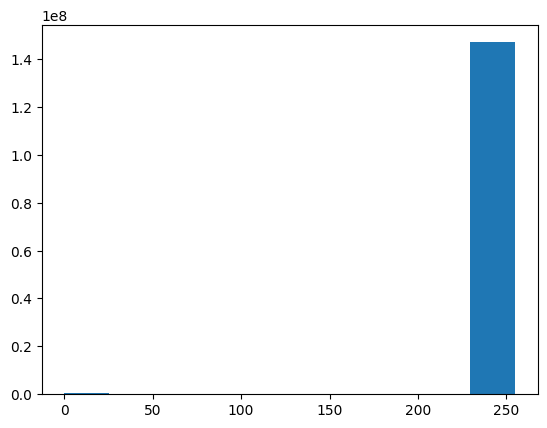

In [19]:
import random
random_images = random.sample(images, 100)

# concatenate the pixels of the subset images into one array
all_pixels = np.concatenate([image.ravel() for image in random_images])

# plot the distribution of the pixels
plt.hist(all_pixels)
plt.show()

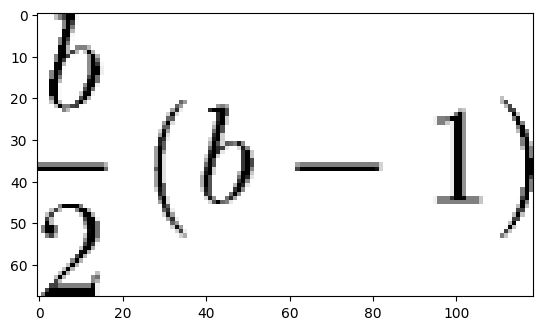

In [5]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread(r"D:\im2latex_data\im2latex-170k\sorted_images\0000017.png", cv2.IMREAD_UNCHANGED)
#Image data of dtype object cannot be converted to float
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)